## multivariate time series : 

using multiple features in time series

In [110]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import grangercausalitytests # for granger causality test

from sklearn.preprocessing import StandardScaler


from statsmodels.tsa.vector_ar.var_model import VAR #vector auto regression model
from statsmodels.tsa.statespace.varmax import VARMAX #Vector Autoregressive Moving Average with eXogenous regressors model

from statsmodels.tsa.seasonal import seasonal_decompose

In [111]:
# train, validation, test split : in time series, you cannot simply split the data using train_test_split() as we have to split the data according to the data. so, we can keep last few months aside for validation purposes and use the rest for the training purposes.

# importing the dataset
df = pd.read_csv('./PRSA_Data_Dingling_20130301-20170228.csv')
df.head(10)

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,3.0,NaN,200.0,82.0,-2.3,1020.8,-19.7,0.0,E,0.5,Dingling
1,2,2013,3,1,1,7.0,7.0,3.0,NaN,200.0,80.0,-2.5,1021.3,-19.0,0.0,ENE,0.7,Dingling
2,3,2013,3,1,2,5.0,5.0,3.0,2.0,200.0,79.0,-3.0,1021.3,-19.9,0.0,ENE,0.2,Dingling
3,4,2013,3,1,3,6.0,6.0,3.0,NaN,200.0,79.0,-3.6,1021.8,-19.1,0.0,NNE,1.0,Dingling
4,5,2013,3,1,4,5.0,5.0,3.0,NaN,200.0,81.0,-3.5,1022.3,-19.4,0.0,N,2.1,Dingling
5,6,2013,3,1,5,6.0,6.0,3.0,4.0,200.0,79.0,-4.5,1022.6,-19.5,0.0,NNW,1.7,Dingling
6,7,2013,3,1,6,5.0,10.0,3.0,4.0,200.0,77.0,-4.5,1023.4,-19.5,0.0,NNW,1.8,Dingling
7,8,2013,3,1,7,5.0,6.0,3.0,2.0,200.0,80.0,-2.1,1024.6,-20.0,0.0,NW,2.5,Dingling
8,9,2013,3,1,8,8.0,7.0,3.0,3.0,200.0,79.0,-0.2,1025.2,-20.5,0.0,NNW,2.8,Dingling
9,10,2013,3,1,9,8.0,8.0,3.0,2.0,200.0,81.0,0.6,1025.3,-20.4,0.0,NNW,3.8,Dingling


In [112]:
df.shape

(35064, 18)

analysing multivariate time series data : 

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       35064 non-null  int64  
 1   year     35064 non-null  int64  
 2   month    35064 non-null  int64  
 3   day      35064 non-null  int64  
 4   hour     35064 non-null  int64  
 5   PM2.5    34285 non-null  float64
 6   PM10     34408 non-null  float64
 7   SO2      34334 non-null  float64
 8   NO2      33830 non-null  float64
 9   CO       33052 non-null  float64
 10  O3       33850 non-null  float64
 11  TEMP     35011 non-null  float64
 12  PRES     35014 non-null  float64
 13  DEWP     35011 non-null  float64
 14  RAIN     35013 non-null  float64
 15  wd       34924 non-null  object 
 16  WSPM     35021 non-null  float64
 17  station  35064 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 4.8+ MB


In [114]:
# combining year, month, day and hour into one
df['dt'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

In [115]:
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,dt
0,1,2013,3,1,0,4.0,4.0,3.0,NaN,200.0,82.0,-2.3,1020.8,-19.7,0.0,E,0.5,Dingling,2013-03-01 00:00:00
1,2,2013,3,1,1,7.0,7.0,3.0,NaN,200.0,80.0,-2.5,1021.3,-19.0,0.0,ENE,0.7,Dingling,2013-03-01 01:00:00
2,3,2013,3,1,2,5.0,5.0,3.0,2.0,200.0,79.0,-3.0,1021.3,-19.9,0.0,ENE,0.2,Dingling,2013-03-01 02:00:00
3,4,2013,3,1,3,6.0,6.0,3.0,NaN,200.0,79.0,-3.6,1021.8,-19.1,0.0,NNE,1.0,Dingling,2013-03-01 03:00:00
4,5,2013,3,1,4,5.0,5.0,3.0,NaN,200.0,81.0,-3.5,1022.3,-19.4,0.0,N,2.1,Dingling,2013-03-01 04:00:00


In [116]:
# setting datetime as index
df = df.set_index('dt')

In [117]:
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
dt,,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,1,2013,3,1,0,4.0,4.0,3.0,NaN,200.0,82.0,-2.3,1020.8,-19.7,0.0,E,0.5,Dingling
2013-03-01 01:00:00,2,2013,3,1,1,7.0,7.0,3.0,NaN,200.0,80.0,-2.5,1021.3,-19.0,0.0,ENE,0.7,Dingling
2013-03-01 02:00:00,3,2013,3,1,2,5.0,5.0,3.0,2.0,200.0,79.0,-3.0,1021.3,-19.9,0.0,ENE,0.2,Dingling
2013-03-01 03:00:00,4,2013,3,1,3,6.0,6.0,3.0,NaN,200.0,79.0,-3.6,1021.8,-19.1,0.0,NNE,1.0,Dingling
2013-03-01 04:00:00,5,2013,3,1,4,5.0,5.0,3.0,NaN,200.0,81.0,-3.5,1022.3,-19.4,0.0,N,2.1,Dingling


In [9]:
df.describe()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,34285.000000,34408.000000,34334.000000,33830.000000,33052.000000,33850.000000,35011.000000,35014.000000,35011.000000,35013.000000,35021.000000
mean,17532.500000,2014.662560,6.522930,15.729637,11.500000,65.989497,83.739723,11.749650,27.585467,904.896073,68.548371,13.686111,1007.760278,1.505495,0.060366,1.853836
std,10122.249256,1.177213,3.448752,8.800218,6.922285,72.267723,79.541685,15.519259,26.383882,903.306220,53.764424,11.365313,10.225664,13.822099,0.752899,1.309808
min,1.000000,2013.000000,1.000000,1.000000,0.000000,3.000000,2.000000,0.285600,1.026500,100.000000,0.214200,-16.600000,982.400000,-35.100000,0.000000,0.000000
25%,8766.750000,2014.000000,4.000000,8.000000,5.750000,14.000000,26.000000,2.000000,9.000000,300.000000,31.000000,3.400000,999.300000,-10.200000,0.000000,1.000000
50%,17532.500000,2015.000000,7.000000,16.000000,11.500000,41.000000,60.000000,5.000000,19.000000,600.000000,61.000000,14.700000,1007.400000,1.800000,0.000000,1.500000
75%,26298.250000,2016.000000,10.000000,23.000000,17.250000,93.000000,117.000000,15.000000,38.000000,1200.000000,90.000000,23.300000,1016.000000,14.200000,0.000000,2.300000
max,35064.000000,2017.000000,12.000000,31.000000,23.000000,881.000000,905.000000,156.000000,205.000000,10000.000000,500.000000,41.400000,1036.500000,27.200000,52.100000,10.000000


### visualizing 

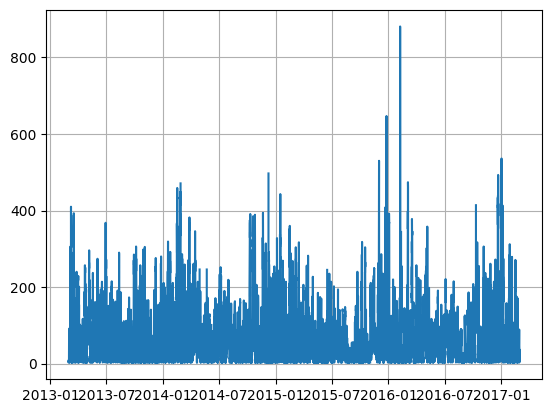

In [ ]:
plt.plot(df['PM2.5'])
plt.grid()
plt.show()

the above graph represents the non-stationary data

In [ ]:
df['2014' : '2016'][['month', 'PM2.5', 'TEMP']].groupby('month').agg({'PM2.5' : ['max'], 'TEMP' : ['min', 'max']})

PM2.5  TEMP      
         max   min   max
month                   
1      443.0 -16.6  12.4
2      881.0 -10.9  14.0
3      474.0  -6.4  26.0
4      346.0   1.3  32.0
5      358.0   7.0  41.4
6      245.0  15.1  38.1
7      252.0  16.8  39.2
8      217.0  16.6  36.3
9      240.0   7.8  34.5
10     414.0  -1.4  28.1
11     394.0 -10.3  20.8
12     647.0  -9.7  11.6

you can notice that as the temperature decreases, the PM2.5 value increases and vice-versa.

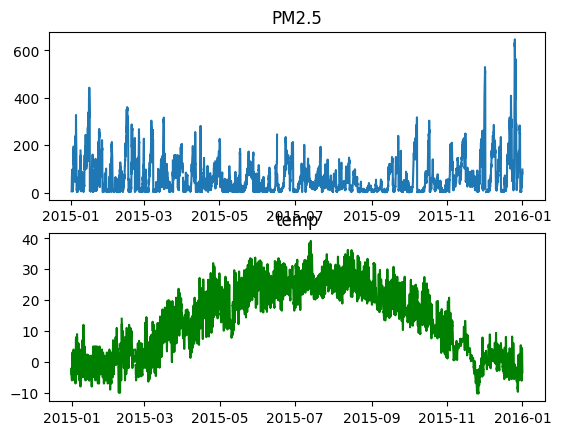

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 1)
ax[0].plot(df[df.year == 2015]['PM2.5'])
ax[0].set_title('PM2.5')
ax[1].plot(df[df.year == 2015]['TEMP'], color = 'green')
ax[1].set_title('temp')

plt.show()

you can clearly see that the 'PM2.5' and 'temp' are inversly proportional

array([[<AxesSubplot: title={'center': 'PM2.5'}>,
        <AxesSubplot: title={'center': 'TEMP'}>]], dtype=object)

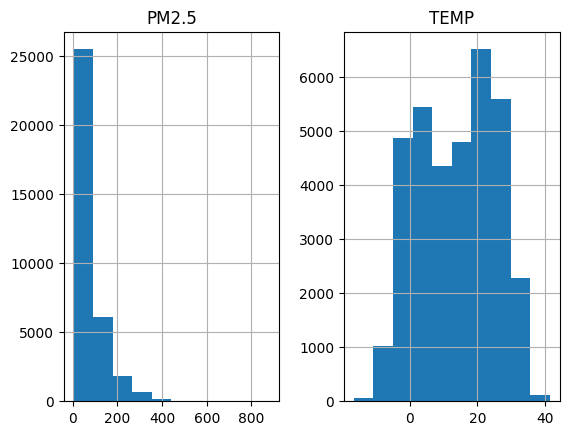

In [ ]:
df[['PM2.5', 'TEMP']].hist()

<AxesSubplot: ylabel='Density'>

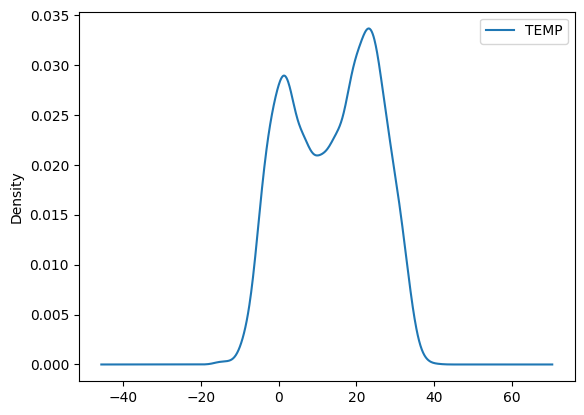

In [ ]:
df[['TEMP']].plot(kind = 'density')

<AxesSubplot: ylabel='Density'>

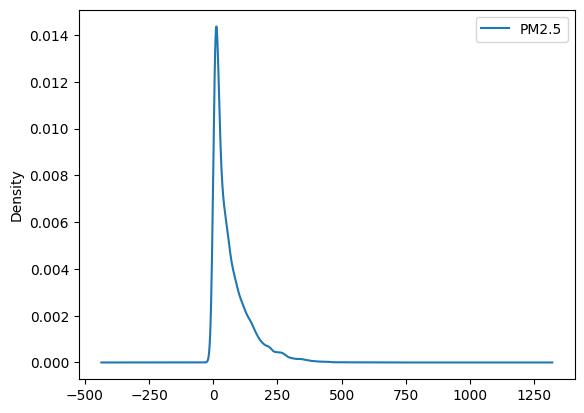

In [ ]:
df[['PM2.5']].plot(kind = 'density')

lag plots

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 1)'>

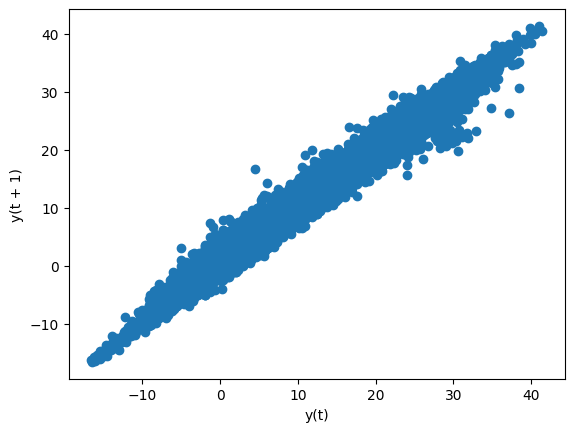

In [ ]:
# with lag = 1
pd.plotting.lag_plot(df['TEMP'], lag = 1)

lag_plot plots the scatter plot for the data with respect to its lag. for example, for lag = 1, it will plot y(t) as x-axis with y(t+1) i.e., next data point as y-axis

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 10)'>

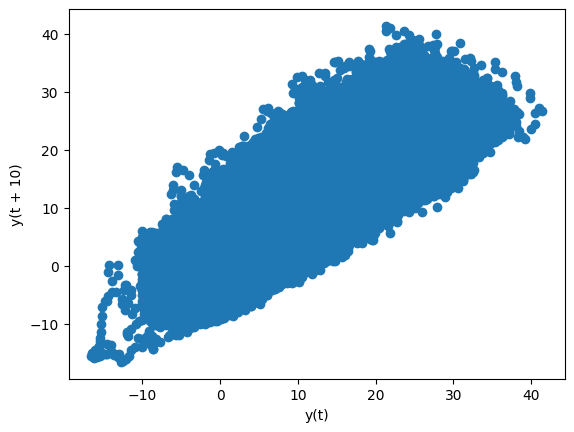

In [ ]:
# with lag = 10
pd.plotting.lag_plot(df['TEMP'], lag = 10)

you can notice that in the plot where lag = 1, the line is more linear(narrow) than the plot with lag = 10. this is because, in lag = 1, there is not much difference in the value as the temperature values are just 1 hour apart but in lag = 10, there is much more difference in the temperature values between 10 hours.

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 24)'>

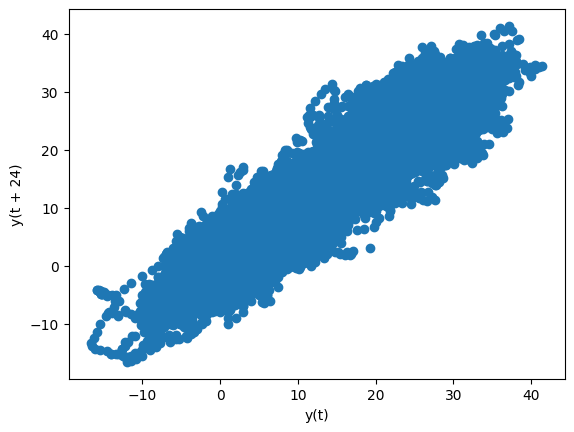

In [ ]:
# with lag = 24
pd.plotting.lag_plot(df['TEMP'], lag = 24)

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 4320)'>

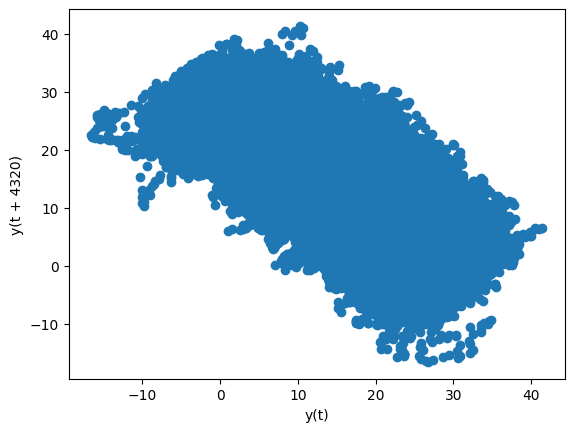

In [ ]:
# with lag = 4320
pd.plotting.lag_plot(df['TEMP'], lag = 4320)  # for 6 months

#here you will see negative correlation because in 6 months the temperature reduces as the season changes from summmer to winter

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 2160)'>

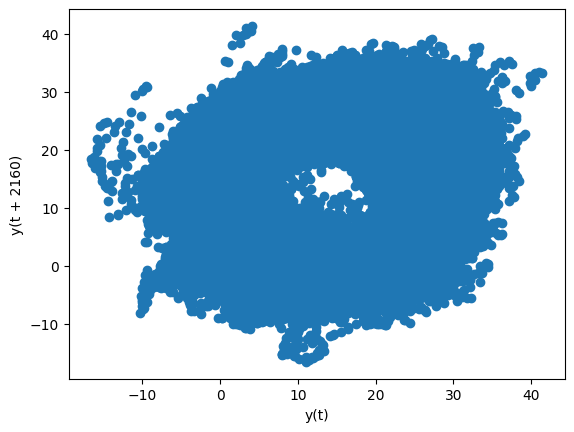

In [ ]:
# with lag = 2160
pd.plotting.lag_plot(df['TEMP'], lag = 2160)  #no correlation

array([<AxesSubplot: xlabel='datetime'>, <AxesSubplot: xlabel='datetime'>,
       <AxesSubplot: xlabel='datetime'>], dtype=object)

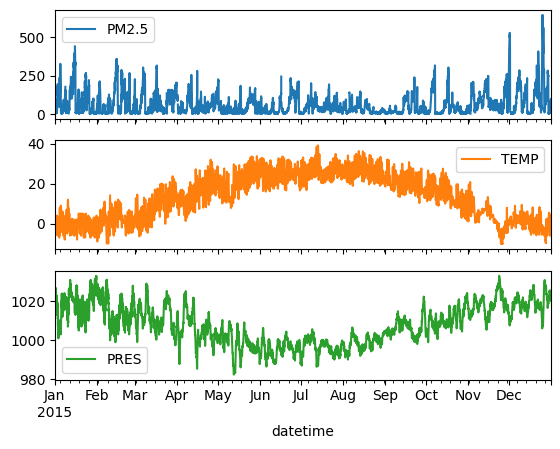

In [ ]:
df[df.year == 2015][['PM2.5', 'TEMP', 'PRES']].plot(subplots = True)

you can notice that the pressure and temperature are also inversly proportional

array([<AxesSubplot: xlabel='datetime'>, <AxesSubplot: xlabel='datetime'>,
       <AxesSubplot: xlabel='datetime'>, <AxesSubplot: xlabel='datetime'>,
       <AxesSubplot: xlabel='datetime'>], dtype=object)

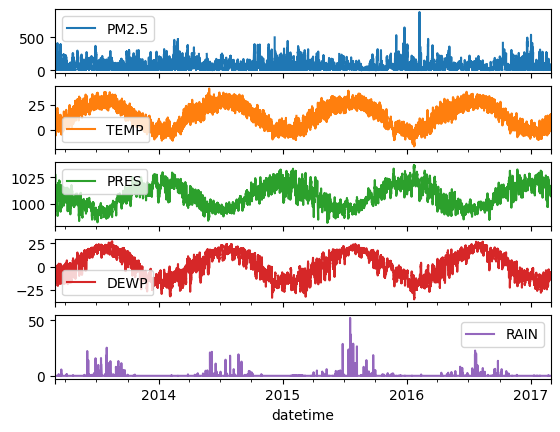

In [ ]:
df[['PM2.5', 'TEMP', 'PRES', 'DEWP', 'RAIN']].plot(subplots = True)

array([<AxesSubplot: xlabel='dt'>, <AxesSubplot: xlabel='dt'>,
       <AxesSubplot: xlabel='dt'>, <AxesSubplot: xlabel='dt'>,
       <AxesSubplot: xlabel='dt'>, <AxesSubplot: xlabel='dt'>,
       <AxesSubplot: xlabel='dt'>, <AxesSubplot: xlabel='dt'>,
       <AxesSubplot: xlabel='dt'>, <AxesSubplot: xlabel='dt'>,
       <AxesSubplot: xlabel='dt'>, <AxesSubplot: xlabel='dt'>,
       <AxesSubplot: xlabel='dt'>, <AxesSubplot: xlabel='dt'>,
       <AxesSubplot: xlabel='dt'>, <AxesSubplot: xlabel='dt'>],
      dtype=object)

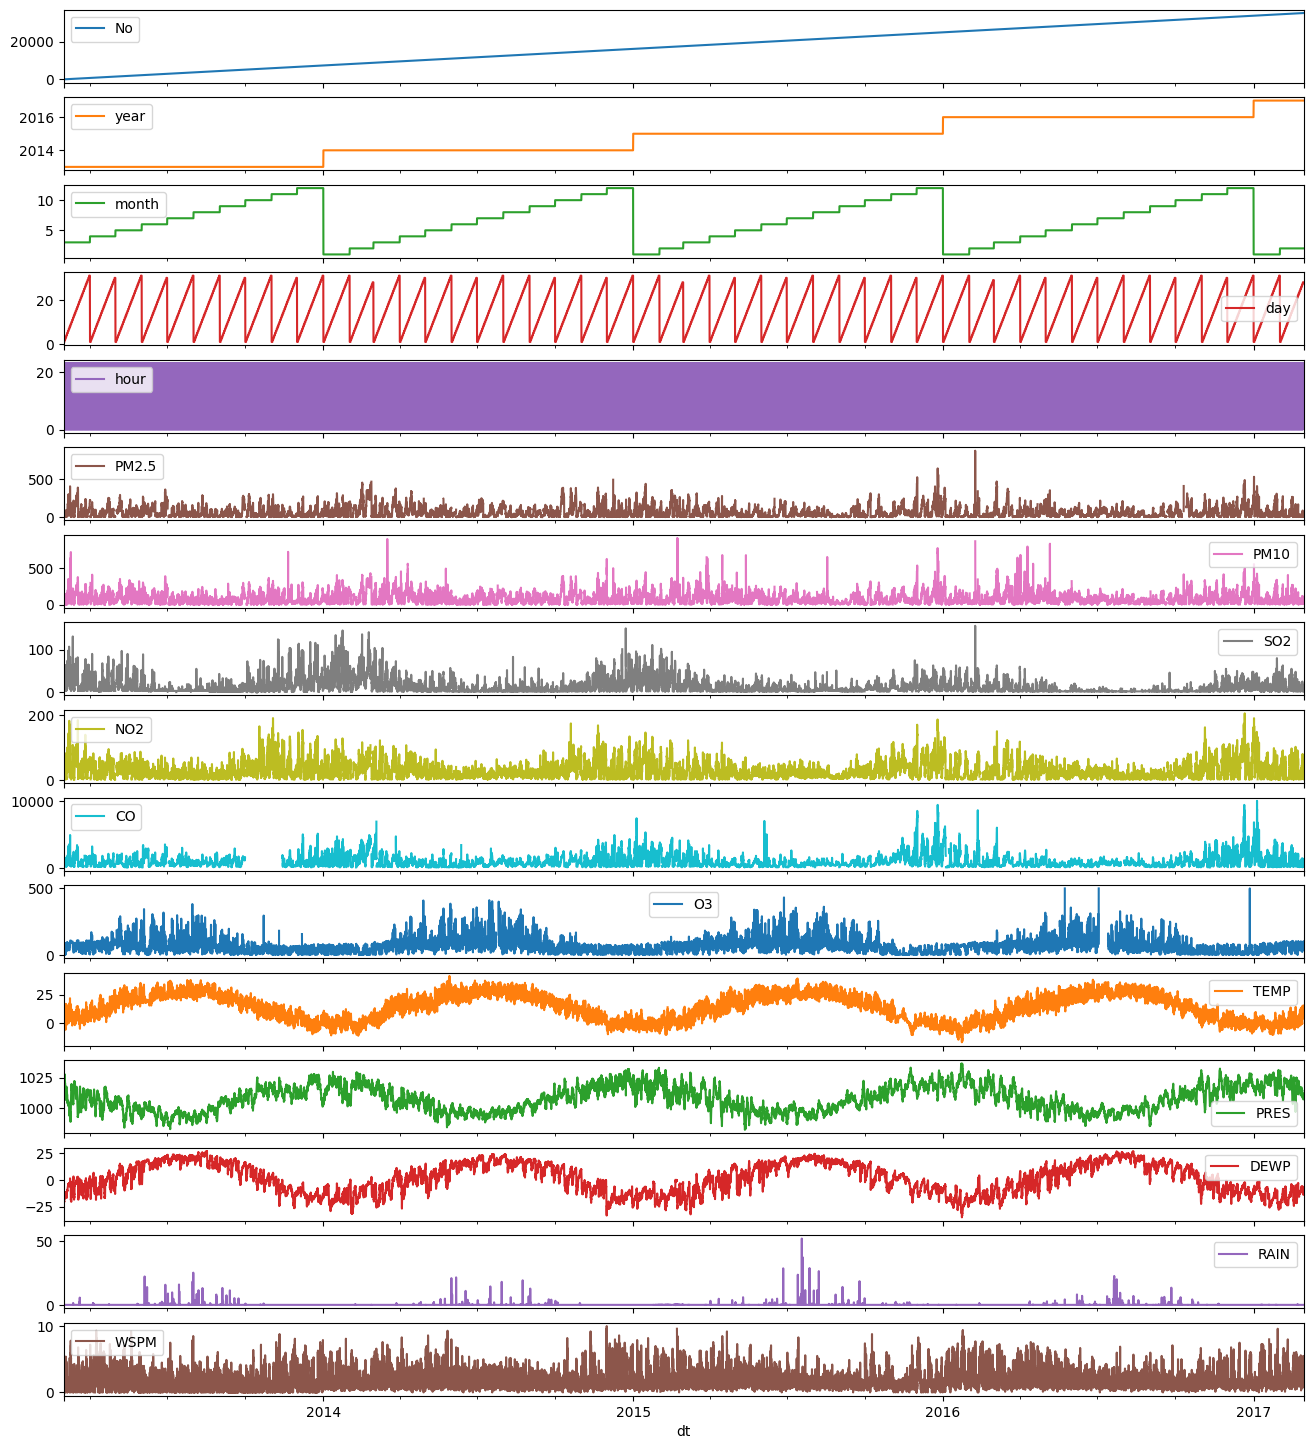

In [ ]:
df.plot(subplots = True, figsize=(16, 18))

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

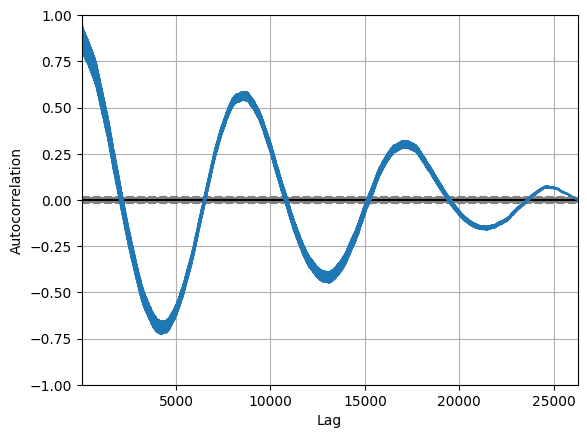

In [ ]:
pd.plotting.autocorrelation_plot(df['2014' : '2016']['TEMP'].dropna())

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

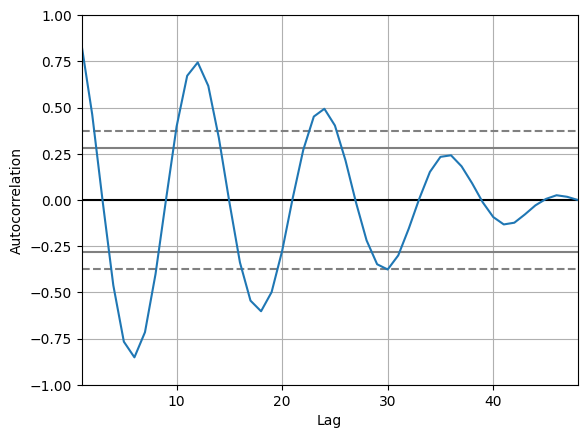

In [ ]:
pd.plotting.autocorrelation_plot(df['TEMP'].dropna().resample('1ME').mean())   # resamples the data for 1 month

straight horizontal line represents 90% confidence interval and dotted line represents 95% confidence interval.

you can notice that the temperature peaks every 12 months so we can say that the data has seasonality

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

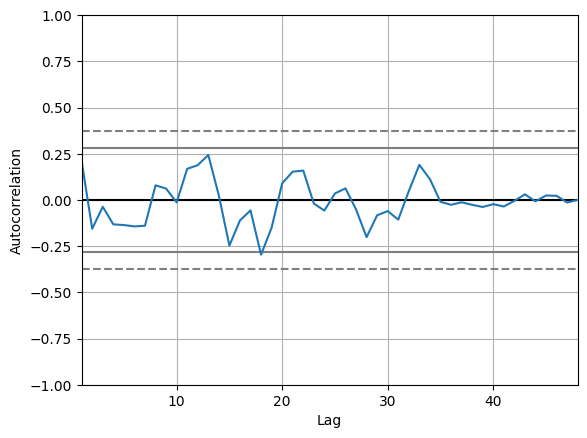

In [ ]:
pd.plotting.autocorrelation_plot(df['PM2.5'].dropna().resample('1ME').mean())

### handling missing values in time series data

In [118]:
df.drop(['year', 'month', 'day', 'hour', 'No'], axis = 1, inplace = True)

In [71]:
df.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
dt,,,,,,,,,,,,,
2013-03-01 00:00:00,4.0,4.0,3.0,NaN,200.0,82.0,-2.3,1020.8,-19.7,0.0,E,0.5,Dingling
2013-03-01 01:00:00,7.0,7.0,3.0,NaN,200.0,80.0,-2.5,1021.3,-19.0,0.0,ENE,0.7,Dingling
2013-03-01 02:00:00,5.0,5.0,3.0,2.0,200.0,79.0,-3.0,1021.3,-19.9,0.0,ENE,0.2,Dingling
2013-03-01 03:00:00,6.0,6.0,3.0,NaN,200.0,79.0,-3.6,1021.8,-19.1,0.0,NNE,1.0,Dingling
2013-03-01 04:00:00,5.0,5.0,3.0,NaN,200.0,81.0,-3.5,1022.3,-19.4,0.0,N,2.1,Dingling


In [11]:
df.shape

(35064, 13)

In [12]:
df.isnull().sum()  

PM2.5       779
PM10        656
SO2         730
NO2        1234
CO         2012
O3         1214
TEMP         53
PRES         50
DEWP         53
RAIN         51
wd          140
WSPM         43
station       0
dtype: int64

In [13]:
# handling missing values of TEMP column

new_df = pd.DataFrame()
new_df['temp_original'] = df['TEMP']

In [14]:
# method 1 - forward fill - fills NaN with previous value 
new_df['temp_ffill'] = df['TEMP'].fillna(method ='ffill')
new_df['2015-02-03 20:00:00':'2015-02-04 10:00:00']

C:\Users\RAJESH\AppData\Local\Temp\ipykernel_7592\1566008013.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_df['temp_ffill'] = df['TEMP'].fillna(method ='ffill')


,temp_original,temp_ffill
dt,,
2015-02-03 20:00:00,3.0,3.0
2015-02-03 21:00:00,3.0,3.0
2015-02-03 22:00:00,1.0,1.0
2015-02-03 23:00:00,0.0,0.0
2015-02-04 00:00:00,-1.0,-1.0
2015-02-04 01:00:00,-1.0,-1.0
2015-02-04 02:00:00,-1.0,-1.0
2015-02-04 03:00:00,-1.0,-1.0
2015-02-04 04:00:00,-2.0,-2.0


In [15]:
# method 2 - backward fill - fills NaN with next value 
new_df['temp_bfill'] = df['TEMP'].fillna(method ='bfill')
new_df['2015-02-03 20:00:00':'2015-02-04 11:00:00']

C:\Users\RAJESH\AppData\Local\Temp\ipykernel_7592\1096511427.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_df['temp_bfill'] = df['TEMP'].fillna(method ='bfill')


,temp_original,temp_ffill,temp_bfill
dt,,,
2015-02-03 20:00:00,3.0,3.0,3.0
2015-02-03 21:00:00,3.0,3.0,3.0
2015-02-03 22:00:00,1.0,1.0,1.0
2015-02-03 23:00:00,0.0,0.0,0.0
2015-02-04 00:00:00,-1.0,-1.0,-1.0
2015-02-04 01:00:00,-1.0,-1.0,-1.0
2015-02-04 02:00:00,-1.0,-1.0,-1.0
2015-02-04 03:00:00,-1.0,-1.0,-1.0
2015-02-04 04:00:00,-2.0,-2.0,-2.0


ffill and bfill is not optimal in every case. for example, consider that you are handling sales data and you notice that sales usually peak during weekends. in this case, simply filling NaNs with ffill and bfill is not the best. instead we can fill the value of previous sunday. for this we will use lag_plots to see which lag has most linear correlated.

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 1)'>

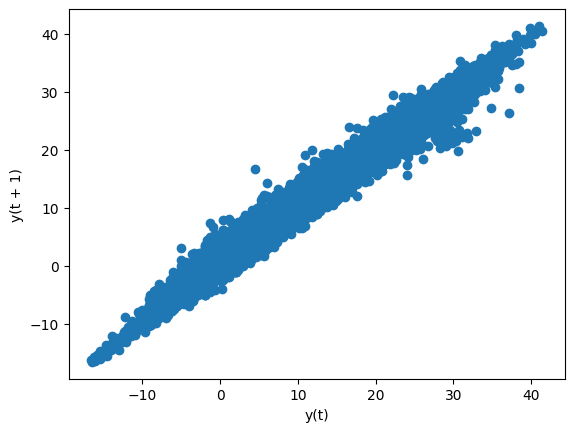

In [16]:
pd.plotting.lag_plot(df['TEMP'].dropna(), lag = 1)  # previous hour

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 24)'>

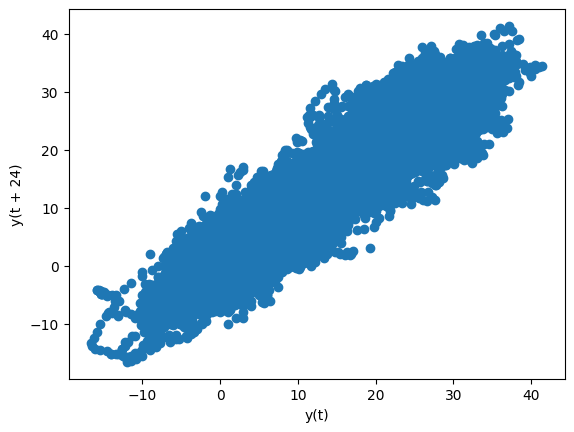

In [17]:
pd.plotting.lag_plot(new_df.temp_original.dropna(), lag = 24)  # same hour, previous day

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 8760)'>

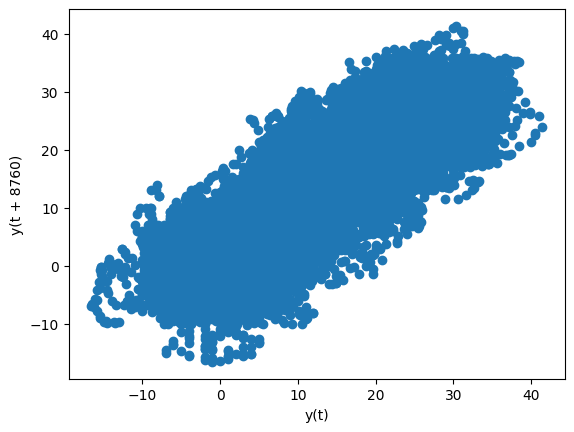

In [18]:
pd.plotting.lag_plot(new_df.temp_original.dropna(), lag = 8760)   #same hour, previous year

out of all the graphs, we can see that the previous hour temperature is more linear with the current temperature(see graph 1). so, in this case, its better to use ffill()

In [19]:
# method 3 : rolling window - here we use rolling average to fill the NaN values(we have discussed what rolling window is in univariate time series analysis)
new_df['temp_rolling'] = new_df['temp_original'].rolling(window = 3, min_periods=1).mean() #larger the window value, more smooth the rolling average is
new_df['2015-02-03 20:00:00':'2015-02-04 11:00:00']



# you can also try to apply rolling window only to the NaN values.

,temp_original,temp_ffill,temp_bfill,temp_rolling
dt,,,,
2015-02-03 20:00:00,3.0,3.0,3.0,4.333333
2015-02-03 21:00:00,3.0,3.0,3.0,3.666667
2015-02-03 22:00:00,1.0,1.0,1.0,2.333333
2015-02-03 23:00:00,0.0,0.0,0.0,1.333333
2015-02-04 00:00:00,-1.0,-1.0,-1.0,0.000000
2015-02-04 01:00:00,-1.0,-1.0,-1.0,-0.666667
2015-02-04 02:00:00,-1.0,-1.0,-1.0,-1.000000
2015-02-04 03:00:00,-1.0,-1.0,-1.0,-1.000000
2015-02-04 04:00:00,-2.0,-2.0,-2.0,-1.333333


In [20]:
# method 4 .
# sometimes we will need to apply own domain knowledge to solve some problems. for example, in this case we know that temperature difference happens gradually(if at first hour, the temperature is 10 C and at third hour, the temperature is 15 C so we can conclude that at 2nd hour, most probabily the temperature should be around ~12.5 C as change in temperature happens gradually), we can fill the NaN values with average of pervious and after hour.

temp = new_df.temp_original
avgs = []

for i in range(len(temp)) : 
    if pd.isna(temp[i]):
        avgs.append((temp[i-1] + temp[i+1]) / 2)
    else:
        avgs.append(temp[i])

# def avg_temp(x):
#     if pd.isna(x['temp_original']) : 
#         a = new_df[new_df.dt == x['dt'] - pd.offsets.DateOffset(hours = -1)]['temp_average']  #next hour temperature
#         b = new_df[new_df.dt == x['dt'] - pd.offsets.DateOffset(hours = 1)]['temp_average']  # previous hour temperature
#         avgs = (a+b)/2
#     else:
#         new_df['temp_average'] = x['temp_original']


new_df['temp_average'] = avgs
new_df['2015-02-03 20:00:00':'2015-02-04 11:00:00']

C:\Users\RAJESH\AppData\Local\Temp\ipykernel_7592\1073636365.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if pd.isna(temp[i]):
C:\Users\RAJESH\AppData\Local\Temp\ipykernel_7592\1073636365.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  avgs.append(temp[i])
C:\Users\RAJESH\AppData\Local\Temp\ipykernel_7592\1073636365.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  avgs.append((temp[i-1] + temp[i+1]) / 2)


,temp_original,temp_ffill,temp_bfill,temp_rolling,temp_average
dt,,,,,
2015-02-03 20:00:00,3.0,3.0,3.0,4.333333,3.0
2015-02-03 21:00:00,3.0,3.0,3.0,3.666667,3.0
2015-02-03 22:00:00,1.0,1.0,1.0,2.333333,1.0
2015-02-03 23:00:00,0.0,0.0,0.0,1.333333,0.0
2015-02-04 00:00:00,-1.0,-1.0,-1.0,0.000000,-1.0
2015-02-04 01:00:00,-1.0,-1.0,-1.0,-0.666667,-1.0
2015-02-04 02:00:00,-1.0,-1.0,-1.0,-1.000000,-1.0
2015-02-04 03:00:00,-1.0,-1.0,-1.0,-1.000000,-1.0
2015-02-04 04:00:00,-2.0,-2.0,-2.0,-1.333333,-2.0


In [119]:
# we will now impute the missing values in the main dataset
def get_next_value(index, data):
    if pd.isna(data.iloc[index]):
        return get_next_value(index = index+1, data = data)
    else:
        return data.iloc[index]
    
def get_previous_value(index, data):
    if pd.isna(data.iloc[index]):
        return get_previous_value(index = index-1, data = data)
    else:
        return data.iloc[index]

for i in ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP',
       'RAIN', 'WSPM']:
    lst = df[i]
    imputed_values = []
    for j in range(len(lst)):
        if pd.isna(lst.iloc[j]):
            a = get_previous_value(index = j-1, data = lst)
            b = get_next_value(index = j+1, data = lst)
            imputed_values.append((int(a)+int(b))/2)
        else:
            imputed_values.append(lst.iloc[j])
    df[i] = imputed_values

# imputing 'WD' column
# since wind direction doesn't change that much within 1 hour, we will just fill previous values.
df.wd = df.wd.ffill()

df.isnull().sum()

PM2.5      0
PM10       0
SO2        0
NO2        0
CO         0
O3         0
TEMP       0
PRES       0
DEWP       0
RAIN       0
wd         0
WSPM       0
station    0
dtype: int64

we could have also used simpleImputer, iterative imputer or supervised learning methods to fill the null values

In [120]:
# dropping 'station' and 'wd' feature 
df.drop(['station', 'wd'],axis = 1, inplace = True)

### moving averages
we use moving average to smoothen the short term fluctuations 

In [23]:
df['2013-03-01 00:00:00' : '2013-04-01 00:00:00']

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
dt,,,,,,,,,,,
2013-03-01 00:00:00,4.0,4.0,3.0,5.5,200.0,82.0,-2.3,1020.8,-19.7,0.0,0.5
2013-03-01 01:00:00,7.0,7.0,3.0,5.5,200.0,80.0,-2.5,1021.3,-19.0,0.0,0.7
2013-03-01 02:00:00,5.0,5.0,3.0,2.0,200.0,79.0,-3.0,1021.3,-19.9,0.0,0.2
2013-03-01 03:00:00,6.0,6.0,3.0,3.0,200.0,79.0,-3.6,1021.8,-19.1,0.0,1.0
2013-03-01 04:00:00,5.0,5.0,3.0,3.0,200.0,81.0,-3.5,1022.3,-19.4,0.0,2.1
...,...,...,...,...,...,...,...,...,...,...,...
2013-03-31 20:00:00,203.0,228.0,10.0,58.0,1200.0,14.0,5.7,1006.7,2.3,0.0,1.0
2013-03-31 21:00:00,213.0,218.0,10.0,54.0,1300.0,17.0,5.8,1007.0,2.6,0.0,1.3
2013-03-31 22:00:00,215.0,228.0,11.0,63.0,1399.0,8.0,6.0,1006.0,2.8,0.0,1.3


In [24]:
mov_avg = pd.DataFrame()
mov_avg['pm2.5'] = df['PM2.5']['2013']


# rolling window - msot common method(already discussed in the time_series.ipynb file)
mov_avg['pm2.5_rolling'] = mov_avg['pm2.5'].rolling(window = 3).mean()

# rolling window with shift = 1
mov_avg['pm2.5_rolling_shift1'] = mov_avg['pm2.5'].rolling(window = 3).mean().shift(1) #shifts the value by index of 1

# weighted moving average
# formula : [(t-n * weighted factor) + (t - (n-1) * weighted factor) ... + (t * weighted factor)] / n
def wma(weights) : 
    def calculate(x):
        return (weights*x).mean()
    return calculate

mov_avg['pm2.5_wma'] = mov_avg['pm2.5'].rolling(window = 3).apply(wma([0.5, 1.0, 1.5])).shift(1)
                                                                #      weights - nummber of weights should be equal to 'window' value
                                                                # the weights should either add up to the 'window' value or 
                                                                # should addup to 1(in this case, remove mean() from the formula in the function defined above)


# exponential moving window/expoenetial weighted mean
mov_avg['pm2.5_ema'] = mov_avg['pm2.5'].ewm(span = 3, adjust = False, min_periods = 3).mean().shift(1)

# exponential smoothing average
mov_avg['pm2.5_esa'] = mov_avg['pm2.5'].ewm(alpha=0.7, adjust = False, min_periods = 3).mean().shift(1)
                                            # alpha range = 0 to 1. if alpha value closer to 1, then the weight value of latest values will be more and if the alpha value closer to 0, then the weight value of older values will be more(which means older values will be given more importance)

mov_avg.head(15)

,pm2.5,pm2.5_rolling,pm2.5_rolling_shift1,pm2.5_wma,pm2.5_ema,pm2.5_esa
dt,,,,,,
2013-03-01 00:00:00,4.0,NaN,NaN,NaN,NaN,NaN
2013-03-01 01:00:00,7.0,NaN,NaN,NaN,NaN,NaN
2013-03-01 02:00:00,5.0,5.333333,NaN,NaN,NaN,NaN
2013-03-01 03:00:00,6.0,6.000000,5.333333,5.500000,5.250000,5.330000
2013-03-01 04:00:00,5.0,5.333333,6.000000,5.833333,5.625000,5.799000
2013-03-01 05:00:00,6.0,5.666667,5.333333,5.333333,5.312500,5.239700
2013-03-01 06:00:00,5.0,5.333333,5.666667,5.666667,5.656250,5.771910
2013-03-01 07:00:00,5.0,5.333333,5.333333,5.333333,5.328125,5.231573
2013-03-01 08:00:00,8.0,6.000000,5.333333,5.166667,5.164062,5.069472


<AxesSubplot: xlabel='dt'>

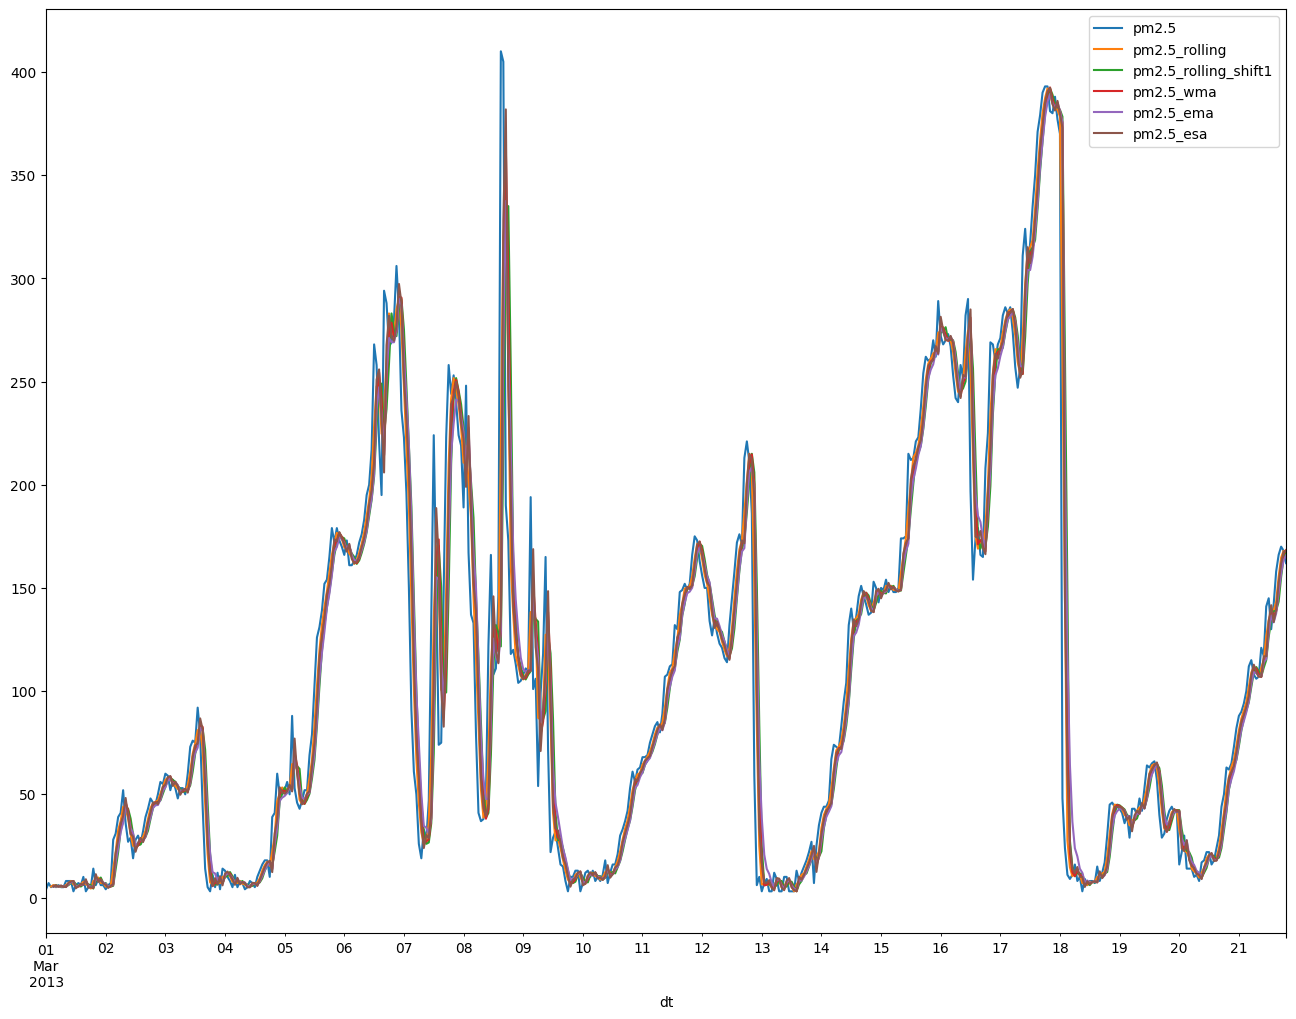

In [25]:
mov_avg.iloc[:500].plot(figsize = (16, 12)) 

In [26]:
mov_avg.columns

Index(['pm2.5', 'pm2.5_rolling', 'pm2.5_rolling_shift1', 'pm2.5_wma',
       'pm2.5_ema', 'pm2.5_esa'],
      dtype='object')

In [27]:
# calculating the rmse error rate
mov_avg = mov_avg.fillna(0)
print('error between pm2.5 and pm2.5_rolling = ', mean_squared_error(mov_avg['pm2.5'], mov_avg['pm2.5_rolling']) ** 0.5)
print('error between pm2.5 and pm2.5_rolling_shift1 = ', mean_squared_error(mov_avg['pm2.5'], mov_avg['pm2.5_rolling_shift1']) ** 0.5)
print('error between pm2.5 and pm2.5_wma = ', mean_squared_error(mov_avg['pm2.5'], mov_avg['pm2.5_wma']) ** 0.5)
print('error between pm2.5 and pm2.5_ema = ', mean_squared_error(mov_avg['pm2.5'], mov_avg['pm2.5_ema']) ** 0.5)
print('error between pm2.5 and pm2.5_esa = ', mean_squared_error(mov_avg['pm2.5'], mov_avg['pm2.5_esa']) ** 0.5)

error between pm2.5 and pm2.5_rolling =  13.48543138795331
error between pm2.5 and pm2.5_rolling_shift1 =  22.899967673040262
error between pm2.5 and pm2.5_wma =  20.52810312617137
error between pm2.5 and pm2.5_ema =  20.870229198019036
error between pm2.5 and pm2.5_esa =  18.69142215187346


In [28]:
# checking if the features are stationary

for i in df.columns:
    result = adfuller(df[i])
    if result[1]<0.05:
        print(f'{i} is stationary.\t')
        print(result)
        print('\n')

PM2.5 is stationary.	
(-20.40237625413179, 0.0, 36, 35027, {'1%': -3.4305367068060364, '5%': -2.8616225197964664, '10%': -2.566813922693787}, 301880.0784334464)


PM10 is stationary.	
(-19.148256691163276, 0.0, 50, 35013, {'1%': -3.4305367814665044, '5%': -2.8616225527935106, '10%': -2.566813940257257}, 333444.6657280657)


SO2 is stationary.	
(-14.531198639647721, 5.328008911991153e-27, 49, 35014, {'1%': -3.4305367761316337, '5%': -2.861622550435704, '10%': -2.566813939002258}, 206504.34506053635)


NO2 is stationary.	
(-17.479714874799576, 4.496196738228044e-30, 48, 35015, {'1%': -3.4305367707970675, '5%': -2.8616225480780315, '10%': -2.5668139377473302}, 241265.17235953297)


CO is stationary.	
(-17.23952902876128, 6.1198020232032194e-30, 48, 35015, {'1%': -3.4305367707970675, '5%': -2.8616225480780315, '10%': -2.5668139377473302}, 488261.56806232594)


O3 is stationary.	
(-11.213506042231867, 2.0970672718840664e-20, 52, 35011, {'1%': -3.43053679213716, '5%': -2.8616225575095284, '1

### decomposing time series data

In [29]:
decomp = seasonal_decompose(df['RAIN'], model = 'additive')   #if the data is stationary, we will use 'additive' model else use 'multiplicative' model

# seasonal_decompose() returns cyclic, trend, seasonality and residual components separately
# cyclic - original data
# trend - trend of the data
# seasonality - difference between cyclic and trend
# residual - noise

In [30]:
decomp.observed, decomp.trend, decomp.seasonal, decomp.resid

(dt
 2013-03-01 00:00:00    0.0
 2013-03-01 01:00:00    0.0
 2013-03-01 02:00:00    0.0
 2013-03-01 03:00:00    0.0
 2013-03-01 04:00:00    0.0
                       ... 
 2017-02-28 19:00:00    0.0
 2017-02-28 20:00:00    0.0
 2017-02-28 21:00:00    0.0
 2017-02-28 22:00:00    0.0
 2017-02-28 23:00:00    0.0
 Name: RAIN, Length: 35064, dtype: float64,
 dt
 2013-03-01 00:00:00   NaN
 2013-03-01 01:00:00   NaN
 2013-03-01 02:00:00   NaN
 2013-03-01 03:00:00   NaN
 2013-03-01 04:00:00   NaN
                        ..
 2017-02-28 19:00:00   NaN
 2017-02-28 20:00:00   NaN
 2017-02-28 21:00:00   NaN
 2017-02-28 22:00:00   NaN
 2017-02-28 23:00:00   NaN
 Name: trend, Length: 35064, dtype: float64,
 dt
 2013-03-01 00:00:00   -0.015251
 2013-03-01 01:00:00   -0.012648
 2013-03-01 02:00:00   -0.005662
 2013-03-01 03:00:00   -0.011621
 2013-03-01 04:00:00   -0.014840
                          ...   
 2017-02-28 19:00:00    0.077283
 2017-02-28 20:00:00    0.065365
 2017-02-28 21:00:00    0.0479

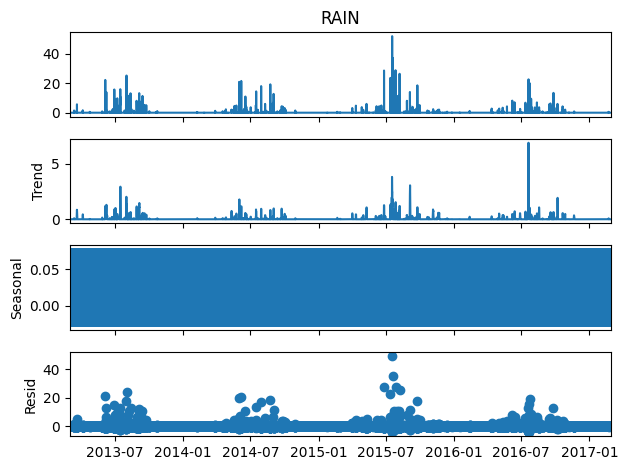

In [31]:
_ = decomp.plot()

<AxesSubplot: xlabel='dt'>

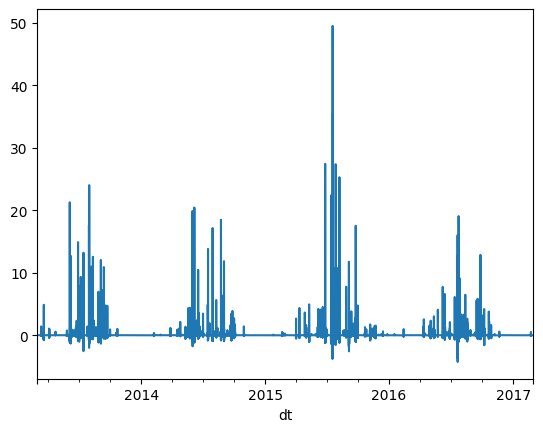

In [32]:
# in additive model, observed data = trend + seasonality + residual
# in multiplicative model, observed data = trend * seasonality * residual

# completely removing the trend component
asd = decomp.observed - decomp.trend #you can also use this to convert the non-stationary data into stationary
asd.plot()

# if you are using multiplicative model, then you should divide it by trend to remove the trend component
# exmpale : deomp.observed / decomp.trend

<AxesSubplot: xlabel='dt'>

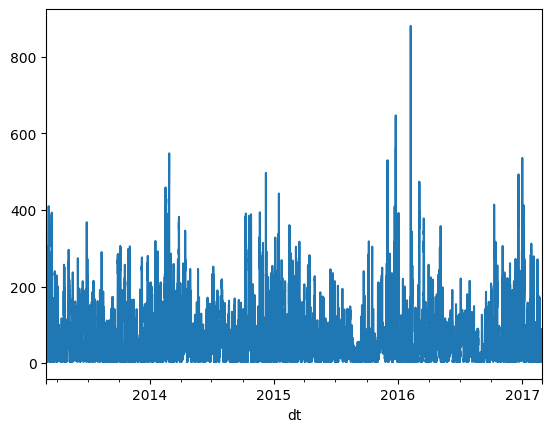

In [33]:
df['PM2.5'].plot()

<AxesSubplot: xlabel='dt'>

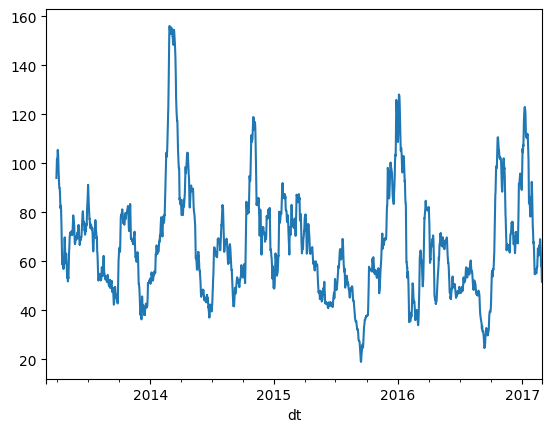

In [34]:
df['PM2.5'].rolling(window = 720).mean().plot()

C:\Users\RAJESH\AppData\Local\Temp\ipykernel_7592\3366229693.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['PM2.5'].resample('M').mean().plot()


<AxesSubplot: xlabel='dt'>

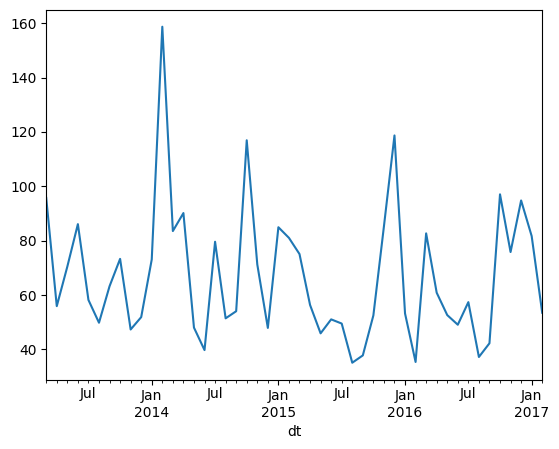

In [35]:
df['PM2.5'].resample('M').mean().plot()

C:\Users\RAJESH\AppData\Local\Temp\ipykernel_7592\4173912843.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['PM2.5'].resample('M').mean().rolling(window = 3).mean().plot()    #more smooth data


<AxesSubplot: xlabel='dt'>

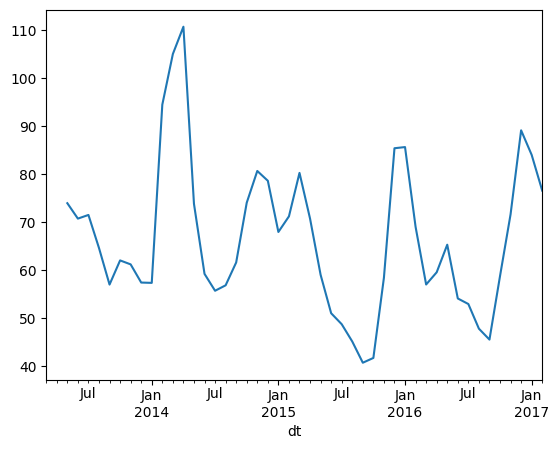

In [36]:
df['PM2.5'].resample('M').mean().rolling(window = 3).mean().plot()    #more smooth data

both rolling() and resample() does the same thing

In [126]:
# smoothing the main dataset
df = df.resample('M').mean()

C:\Users\RAJESH\AppData\Local\Temp\ipykernel_7592\1200683325.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M').mean()


### scaling the data

In [127]:
scaler = StandardScaler()
df = scaler.fit_transform(df)

df = pd.DataFrame(df,columns = scaler.get_feature_names_out())
# NOTE : we could also split the data as train and test and then apply the scaling. if you are splitting the data, before perform missing value imputation, then handle outliers, then scale the data, then check for stationarity, then perform granger causality test, then train and forecast

looks like all the features are stationary else we would have performed log transformation/differencing for the features that is not stationary

Apply differencing
df_diff = df_roll.diff().dropna()
we can perform differencing multiple times also


In [92]:
# now we will perform granger causality test - test to check for causation in the features i.e., wether the feature is cause of another feature. granger causality test suggests potential causation not proof of correlation whereas correlation doesn't imply causation

model = VAR(df)

optimal_lags = model.select_order()
print('optimal lags = ', optimal_lags.selected_orders)

optimal lags =  {'aic': 50, 'bic': 4, 'hqic': 26, 'fpe': 50}


selecting the best lag value : 

BIC: Ideal for larger datasets, models with many features, or when selecting the most parsimonious model is crucial.

AIC: A good general-purpose option, especially for smaller datasets or when prediction accuracy is a priority.

HQIC: A compromise between AIC and BIC, often used when neither of the extremes is clearly preferable.

hypothesis for granger causality test

h0 : x does not cause y

h1 : x causes y

if p-value < 0.05, reject null hypothesis else accept null hypothesis

In [39]:
# performing granger causality test for all the feature combinations

# we will select BIC value in this case
max_lags = optimal_lags.selected_orders['bic']
results = []
for i in df.columns: 
    for j in df.columns:
        result = grangercausalitytests(df[[i, j]], max_lags)
        pvalues = [round(result[k+1][0]['ssr_ftest'][1], 4) for k in range(max_lags)]
        results.append(f'grangercausalitytests({i}, {j}) : pvalues = {pvalues}')


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=35060, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=536073.8046, p=0.0000  , df_denom=35060, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=-0.3769 , p=1.0000  , df_denom=35058, df_num=2


ssr based chi2 test:   chi2=-0.7539 , p=1.0000  , df=2
likelihood ratio test: chi2=-0.7539 , p=1.0000  , df=2
parameter F test:         F=0.0651  , p=0.7986  , df_denom=35058, df_num=1

Granger Causality
number of lags (no zero) 3


c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '


ssr based F test:         F=0.0000  , p=1.0000  , df_denom=35057, df_num=3
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=3
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=3
parameter F test:         F=181344.5033, p=0.0000  , df_denom=35057, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=35055, df_num=4
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=4
likelihood ratio test: chi2=0.0000  , p=1.0000  , df=4
parameter F test:         F=136000.0366, p=0.0000  , df_denom=35055, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=33.7015 , p=0.0000  , df_denom=35060, df_num=1
ssr based chi2 test:   chi2=33.7044 , p=0.0000  , df=1
likelihood ratio test: chi2=33.6882 , p=0.0000  , df=1
parameter F test:         F=33.7015 , p=0.0000  , df_denom=35060, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=107.2488, p=0.0000  , df_denom=35057, df_num=2
s

c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '


ssr based F test:         F=-0.0053 , p=1.0000  , df_denom=35057, df_num=3
ssr based chi2 test:   chi2=-0.0159 , p=1.0000  , df=3
likelihood ratio test: chi2=-0.0159 , p=1.0000  , df=3
parameter F test:         F=0.0007  , p=0.9791  , df_denom=35057, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=35055, df_num=4
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=4
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=4
parameter F test:         F=61475.3276, p=0.0000  , df_denom=35055, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=212.9181, p=0.0000  , df_denom=35060, df_num=1
ssr based chi2 test:   chi2=212.9363, p=0.0000  , df=1
likelihood ratio test: chi2=212.2923, p=0.0000  , df=1
parameter F test:         F=212.9181, p=0.0000  , df_denom=35060, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=210.1343, p=0.0000  , df_denom=35057, df_num=2
ssr b

c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '


ssr based F test:         F=-0.1501 , p=1.0000  , df_denom=35057, df_num=3
ssr based chi2 test:   chi2=-0.4502 , p=1.0000  , df=3
likelihood ratio test: chi2=-0.4503 , p=1.0000  , df=3
parameter F test:         F=0.0394  , p=0.8427  , df_denom=35057, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=-0.0270 , p=1.0000  , df_denom=35055, df_num=4
ssr based chi2 test:   chi2=-0.1079 , p=1.0000  , df=4
likelihood ratio test: chi2=-0.1079 , p=1.0000  , df=4
parameter F test:         F=0.0169  , p=0.9833  , df_denom=35055, df_num=2

Granger Causality
number of lags (no zero) 1


c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 2
  warnings.warn('covariance of constraints does not have full '


ssr based F test:         F=107.0133, p=0.0000  , df_denom=35060, df_num=1
ssr based chi2 test:   chi2=107.0225, p=0.0000  , df=1
likelihood ratio test: chi2=106.8595, p=0.0000  , df=1
parameter F test:         F=107.0133, p=0.0000  , df_denom=35060, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=113.0123, p=0.0000  , df_denom=35057, df_num=2
ssr based chi2 test:   chi2=226.0568, p=0.0000  , df=2
likelihood ratio test: chi2=225.3312, p=0.0000  , df=2
parameter F test:         F=113.0123, p=0.0000  , df_denom=35057, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=66.8368 , p=0.0000  , df_denom=35054, df_num=3
ssr based chi2 test:   chi2=200.5504, p=0.0000  , df=3
likelihood ratio test: chi2=199.9790, p=0.0000  , df=3
parameter F test:         F=66.8368 , p=0.0000  , df_denom=35054, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=50.9476 , p=0.0000  , df_denom=35051, df_num=4
ssr bas

c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '


ssr based F test:         F=-2.0398 , p=1.0000  , df_denom=35054, df_num=4
ssr based chi2 test:   chi2=-8.1606 , p=1.0000  , df=4
likelihood ratio test: chi2=-8.1615 , p=1.0000  , df=4
parameter F test:         F=0.0139  , p=0.9978  , df_denom=35054, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=75.5363 , p=0.0000  , df_denom=35060, df_num=1
ssr based chi2 test:   chi2=75.5427 , p=0.0000  , df=1
likelihood ratio test: chi2=75.4615 , p=0.0000  , df=1
parameter F test:         F=75.5363 , p=0.0000  , df_denom=35060, df_num=1

Granger Causality
number of lags (no zero) 2


c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  warnings.warn('covariance of constraints does not have full '


ssr based F test:         F=38.9397 , p=0.0000  , df_denom=35057, df_num=2
ssr based chi2 test:   chi2=77.8905 , p=0.0000  , df=2
likelihood ratio test: chi2=77.8041 , p=0.0000  , df=2
parameter F test:         F=38.9397 , p=0.0000  , df_denom=35057, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=26.3652 , p=0.0000  , df_denom=35054, df_num=3
ssr based chi2 test:   chi2=79.1115 , p=0.0000  , df=3
likelihood ratio test: chi2=79.0224 , p=0.0000  , df=3
parameter F test:         F=26.3652 , p=0.0000  , df_denom=35054, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=19.7902 , p=0.0000  , df_denom=35051, df_num=4
ssr based chi2 test:   chi2=79.1812 , p=0.0000  , df=4
likelihood ratio test: chi2=79.0920 , p=0.0000  , df=4
parameter F test:         F=19.7902 , p=0.0000  , df_denom=35051, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=91.5057 , p=0.0000  , df_denom=35060, df_num=1
ssr bas

c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '


ssr based F test:         F=0.0022  , p=1.0000  , df_denom=35054, df_num=4
ssr based chi2 test:   chi2=0.0089  , p=1.0000  , df=4
likelihood ratio test: chi2=0.0089  , p=1.0000  , df=4
parameter F test:         F=0.0146  , p=0.9855  , df_denom=35054, df_num=2


c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 2
  warnings.warn('covariance of constraints does not have full '



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=746.1409, p=0.0000  , df_denom=35060, df_num=1
ssr based chi2 test:   chi2=746.2048, p=0.0000  , df=1
likelihood ratio test: chi2=738.3753, p=0.0000  , df=1
parameter F test:         F=746.1409, p=0.0000  , df_denom=35060, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1642.4102, p=0.0000  , df_denom=35057, df_num=2
ssr based chi2 test:   chi2=3285.2889, p=0.0000  , df=2
likelihood ratio test: chi2=3140.3599, p=0.0000  , df=2
parameter F test:         F=1642.4102, p=0.0000  , df_denom=35057, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1098.5062, p=0.0000  , df_denom=35054, df_num=3
ssr based chi2 test:   chi2=3296.1767, p=0.0000  , df=3
likelihood ratio test: chi2=3150.3096, p=0.0000  , df=3
parameter F test:         F=1098.5062, p=0.0000  , df_denom=35054, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=

c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '


ssr based F test:         F=-0.1697 , p=1.0000  , df_denom=35057, df_num=3
ssr based chi2 test:   chi2=-0.5092 , p=1.0000  , df=3
likelihood ratio test: chi2=-0.5092 , p=1.0000  , df=3
parameter F test:         F=0.2564  , p=0.6126  , df_denom=35057, df_num=1

Granger Causality
number of lags (no zero) 4


c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '


ssr based F test:         F=-0.1109 , p=1.0000  , df_denom=35055, df_num=4
ssr based chi2 test:   chi2=-0.4435 , p=1.0000  , df=4
likelihood ratio test: chi2=-0.4435 , p=1.0000  , df=4
parameter F test:         F=0.0762  , p=0.7826  , df_denom=35055, df_num=1

Granger Causality
number of lags (no zero) 1


c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '


ssr based F test:         F=6.2767  , p=0.0122  , df_denom=35060, df_num=1
ssr based chi2 test:   chi2=6.2773  , p=0.0122  , df=1
likelihood ratio test: chi2=6.2767  , p=0.0122  , df=1
parameter F test:         F=6.2767  , p=0.0122  , df_denom=35060, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=168.3426, p=0.0000  , df_denom=35057, df_num=2
ssr based chi2 test:   chi2=336.7331, p=0.0000  , df=2
likelihood ratio test: chi2=335.1264, p=0.0000  , df=2
parameter F test:         F=168.3426, p=0.0000  , df_denom=35057, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=221.5659, p=0.0000  , df_denom=35054, df_num=3
ssr based chi2 test:   chi2=664.8303, p=0.0000  , df=3
likelihood ratio test: chi2=658.6056, p=0.0000  , df=3
parameter F test:         F=221.5659, p=0.0000  , df_denom=35054, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=240.6952, p=0.0000  , df_denom=35051, df_num=4
ssr bas

c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '


ssr based F test:         F=-0.1287 , p=1.0000  , df_denom=35057, df_num=3
ssr based chi2 test:   chi2=-0.3862 , p=1.0000  , df=3
likelihood ratio test: chi2=-0.3862 , p=1.0000  , df=3
parameter F test:         F=0.2743  , p=0.6005  , df_denom=35057, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=35055, df_num=4
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=4
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=4
parameter F test:         F=1145723.4949, p=0.0000  , df_denom=35055, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=115.1869, p=0.0000  , df_denom=35060, df_num=1
ssr based chi2 test:   chi2=115.1968, p=0.0000  , df=1
likelihood ratio test: chi2=115.0080, p=0.0000  , df=1
parameter F test:         F=115.1869, p=0.0000  , df_denom=35060, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=54.9003 , p=0.0000  , df_denom=35057, df_num=2
ssr

c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '


parameter F test:         F=0.5295  , p=0.4668  , df_denom=35056, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=-4.4022 , p=1.0000  , df_denom=35055, df_num=4
ssr based chi2 test:   chi2=-17.6112, p=1.0000  , df=4
likelihood ratio test: chi2=-17.6157, p=1.0000  , df=4
parameter F test:         F=0.1735  , p=0.6770  , df_denom=35055, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1790  , p=0.6722  , df_denom=35060, df_num=1
ssr based chi2 test:   chi2=0.1790  , p=0.6722  , df=1
likelihood ratio test: chi2=0.1790  , p=0.6722  , df=1
parameter F test:         F=0.1790  , p=0.6722  , df_denom=35060, df_num=1

Granger Causality
number of lags (no zero) 2


c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '


ssr based F test:         F=0.8616  , p=0.4225  , df_denom=35057, df_num=2
ssr based chi2 test:   chi2=1.7235  , p=0.4224  , df=2
likelihood ratio test: chi2=1.7235  , p=0.4224  , df=2
parameter F test:         F=0.8616  , p=0.4225  , df_denom=35057, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8685  , p=0.4565  , df_denom=35054, df_num=3
ssr based chi2 test:   chi2=2.6060  , p=0.4564  , df=3
likelihood ratio test: chi2=2.6059  , p=0.4565  , df=3
parameter F test:         F=0.8685  , p=0.4565  , df_denom=35054, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6622  , p=0.6182  , df_denom=35051, df_num=4
ssr based chi2 test:   chi2=2.6497  , p=0.6181  , df=4
likelihood ratio test: chi2=2.6496  , p=0.6181  , df=4
parameter F test:         F=0.6622  , p=0.6182  , df_denom=35051, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=71.5361 , p=0.0000  , df_denom=35060, df_num=1
ssr bas

c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '


In [40]:
for i in results:
    print(i)

grangercausalitytests(PM2.5, PM2.5) : pvalues = [1.0, 1.0, 1.0, 1.0]
grangercausalitytests(PM2.5, PM10) : pvalues = [0.0, 0.0, 0.0, 0.0]
grangercausalitytests(PM2.5, SO2) : pvalues = [0.0, 0.0, 0.0, 0.0]
grangercausalitytests(PM2.5, NO2) : pvalues = [0.0, 0.0, 0.0, 0.0]
grangercausalitytests(PM2.5, CO) : pvalues = [0.0, 0.0, 0.0, 0.0]
grangercausalitytests(PM2.5, O3) : pvalues = [0.0, 0.0, 0.0, 0.0]
grangercausalitytests(PM2.5, TEMP) : pvalues = [0.0009, 0.0001, 0.0004, 0.0001]
grangercausalitytests(PM2.5, PRES) : pvalues = [0.0279, 0.0, 0.0, 0.0]
grangercausalitytests(PM2.5, DEWP) : pvalues = [0.003, 0.0, 0.0, 0.0]
grangercausalitytests(PM2.5, RAIN) : pvalues = [0.0, 0.0, 0.0, 0.0]
grangercausalitytests(PM2.5, WSPM) : pvalues = [0.0, 0.0, 0.0, 0.0]
grangercausalitytests(PM10, PM2.5) : pvalues = [0.0, 0.0, 0.0, 0.0]
grangercausalitytests(PM10, PM10) : pvalues = [1.0, 1.0, 1.0, 1.0]
grangercausalitytests(PM10, SO2) : pvalues = [0.0, 0.0, 0.0, 0.0]
grangercausalitytests(PM10, NO2) : pval

you can notice that most of the p-values are less than 0.05, which means we can reject the null hypothesis and accept h1(so features are highly correlated)

##### what if there is only one-way granger causality(i.e., x causes y but y does not cause x)?
    in this case, we can use the features to train the VAR model as var model will be able to capture the relationship between the features

##### what if there is no granger causality between 2 features?
    sometimes, even though there is no causation captured by grangercausalitytests(), there might be other form of relation between the features so we can try to use it in VAR model

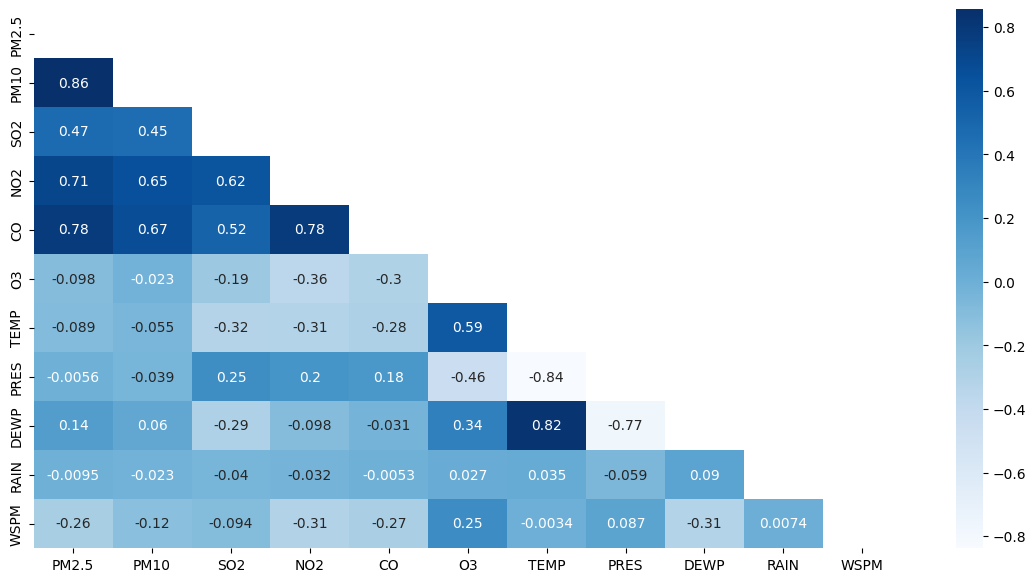

In [41]:
# correlation
plt.subplots(figsize = (14, 7))
mask = np.triu(np.ones_like(df.corr(), dtype = 'bool'))
sns.heatmap(df.corr(), mask = mask, annot = True, cmap = 'Blues')
plt.show()

looks like the features are correlated

In [128]:
# training 

lags = optimal_lags.selected_orders['bic']

result = model.fit(lags)

var_model = result.model
result.summary()

In [ ]:

result = model.fit(lags)

var_model = result.model
result.summary()

In [94]:
# forecasting next 30 days 

horizon = 30*24 # we need to predict 48 data points for the next 2 days
forecast = result.forecast(df.values[-lags:], steps = horizon)

In [95]:
forecast.shape 

(720, 11)

In [96]:
df.shape

(35064, 11)

In [97]:
forecast = pd.DataFrame(forecast, columns  = df.columns, index = range(df.shape[0], df.shape[0]+horizon))
forecast

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
35064,-0.664963,-0.761334,-0.418985,-0.605672,-0.469374,-0.075254,-0.647045,0.203153,-0.963945,-0.057098,-0.166288
35065,-0.633823,-0.696310,-0.353615,-0.572960,-0.457223,-0.194839,-0.684352,0.222229,-0.942884,-0.067943,-0.193756
35066,-0.606477,-0.642896,-0.286519,-0.522532,-0.439737,-0.288033,-0.699157,0.237141,-0.925568,-0.072826,-0.162950
35067,-0.580714,-0.599854,-0.216503,-0.469641,-0.406560,-0.342202,-0.699443,0.253799,-0.913111,-0.081853,-0.099280
35068,-0.552264,-0.550569,-0.147872,-0.417408,-0.381114,-0.371130,-0.687541,0.260838,-0.902744,-0.080761,-0.041760
...,...,...,...,...,...,...,...,...,...,...,...
35779,0.011974,0.014752,0.048806,0.036965,0.029404,-0.044114,-0.097923,0.088522,-0.103276,-0.009075,0.020819
35780,0.011943,0.014714,0.048678,0.036868,0.029327,-0.043999,-0.097665,0.088286,-0.103005,-0.009051,0.020765
35781,0.011911,0.014677,0.048551,0.036772,0.029250,-0.043883,-0.097408,0.088051,-0.102735,-0.009028,0.020712
35782,0.011880,0.014639,0.048424,0.036675,0.029173,-0.043768,-0.097151,0.087817,-0.102465,-0.009004,0.020658


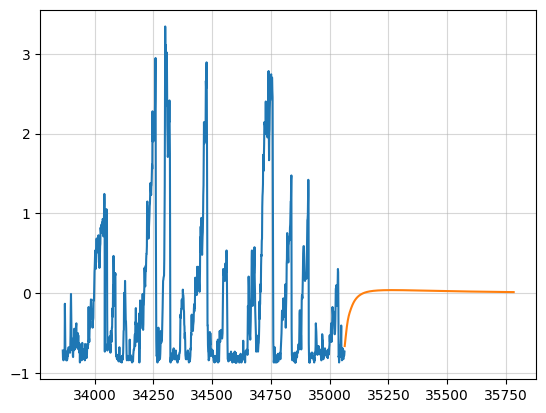

In [98]:
df['PM2.5'][-1200:].plot()
forecast['PM2.5'].plot()
plt.grid(alpha=0.5, which='both')
plt.show()

the predictions are not good. os we will now train VARMAX model

In [129]:
varmax_model = VARMAX(df, exog = None, order = (lags,0))
result = model.fit(method='mle')

result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 27, Apr, 2024
Time:                     13:20:43
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -32.0025
Nobs:                     35063.0    HQIC:                  -32.0242
Log likelihood:           14468.1    FPE:                1.22361e-14
AIC:                     -32.0344    Det(Omega_mle):     1.21902e-14
--------------------------------------------------------------------
Results for equation PM2.5
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.000004         0.001308            0.003           0.998
L1.PM2.5         0.917749         0.003219          285.083           0.000
L1.PM10          0.022392         0.002698            8.299           0.000
L1.S

In [130]:
# forcasting
horizon = 24*100 # forcasting for next 30 days
forecast = result.forecast(df.values[-lags:], steps = horizon)

In [131]:
forecast.shape

(2400, 11)

In [132]:
forecast = pd.DataFrame(forecast, columns = df.columns, index = range(df.shape[0], df.shape[0] + horizon))
forecast

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
48,-0.535574,-0.690729,0.080224,0.010963,-0.128596,-0.261017,-1.091535,1.046399,-1.236922,-0.207890,0.757337
49,-0.525572,-0.628038,0.085677,-0.000675,-0.128204,-0.271763,-1.095211,1.045827,-1.236216,-0.095181,0.606369
50,-0.514464,-0.576647,0.095104,-0.005545,-0.125067,-0.288738,-1.099367,1.046174,-1.234297,-0.074488,0.503464
51,-0.501559,-0.532806,0.107214,-0.005528,-0.119579,-0.308945,-1.103514,1.047182,-1.231708,-0.075451,0.433493
52,-0.487276,-0.494772,0.120960,-0.002160,-0.112387,-0.330580,-1.107390,1.048620,-1.228760,-0.080095,0.385671
...,...,...,...,...,...,...,...,...,...,...,...
2443,-0.000229,0.000044,0.000153,-0.000070,-0.000141,-0.000119,-0.000027,-0.000676,-0.000459,-0.000052,0.000414
2444,-0.000230,0.000043,0.000144,-0.000076,-0.000146,-0.000109,-0.000007,-0.000696,-0.000438,-0.000050,0.000410
2445,-0.000231,0.000042,0.000135,-0.000082,-0.000151,-0.000100,0.000013,-0.000716,-0.000417,-0.000048,0.000406
2446,-0.000231,0.000041,0.000126,-0.000088,-0.000155,-0.000090,0.000033,-0.000736,-0.000396,-0.000046,0.000402


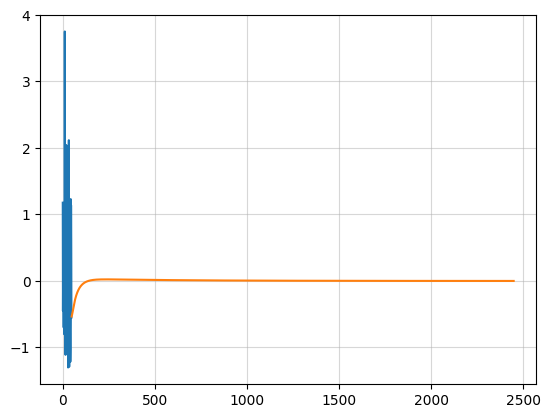

In [133]:
df['PM2.5'][-1200:].plot()
forecast['PM2.5'].plot()
plt.grid(alpha=0.5, which='both')
plt.show()